In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/qvi-data/QVI_data.csv


# Retail Strategy and Analytics

The client has selected store numbers 77, 86 and 88 as trial stores and want
control stores to be established stores that are operational for the entire
observation period.
We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb - Apr 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

Let's first create the metrics of interest and filter the stores that are present
throughout the pre-trial period.

In [2]:
data = pd.read_csv('../input/qvi-data/QVI_data.csv')
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


## Select control stores

I will add a new month ID column in the data with the format yyyymm.

In [3]:
data['month_year'] = pd.to_datetime(data['DATE']).dt.to_period('M')

I will add a new column called PRICE.

In [4]:
data['PRICE'] = data['TOT_SALES'] / data['PROD_QTY']

I will define the measure calculations used during the analysis : total sales, number of customers, number of transactions per customer, number of chips packages per customer, average price per package.

In [5]:
measures_over_time = data.groupby(['STORE_NBR', 'month_year', ], as_index= False).agg(
    totSales = pd.NamedAgg(column="TOT_SALES", aggfunc="sum"),
    nCustomers = pd.NamedAgg(column="LYLTY_CARD_NBR", aggfunc="nunique"),
    nTxnPerStore = pd.NamedAgg(column="TXN_ID", aggfunc="count"),
    nChipsPerStore = pd.NamedAgg(column="PROD_QTY", aggfunc="sum"),
    avgPricePerUnit = pd.NamedAgg(column="PRICE", aggfunc="mean"))

measures_over_time['nTxnPerCust'] =measures_over_time['nTxnPerStore']/measures_over_time['nCustomers']
measures_over_time['nChipsPerTxn'] =measures_over_time['nChipsPerStore']/measures_over_time['nCustomers']

measures_over_time = measures_over_time.drop(labels = ['nTxnPerStore', 'nChipsPerStore'], axis = 1)

measures_over_time

,STORE_NBR,month_year,totSales,nCustomers,avgPricePerUnit,nTxnPerCust,nChipsPerTxn
0,1,2018-07,206.9,49,3.384615,1.061224,1.265306
1,1,2018-08,176.1,42,3.329070,1.023810,1.285714
2,1,2018-09,278.8,59,3.685484,1.050847,1.271186
3,1,2018-10,188.1,44,3.288889,1.022727,1.318182
4,1,2018-11,192.6,46,3.412766,1.021739,1.239130
...,...,...,...,...,...,...,...
3164,272,2019-02,395.5,45,4.358333,1.066667,2.022222
3165,272,2019-03,442.3,50,4.350943,1.060000,2.020000
3166,272,2019-04,445.1,54,4.248214,1.037037,1.944444
3167,272,2019-05,314.6,34,4.437500,1.176471,2.088235


In measures_over_time are no null values.

In [6]:
measures_over_time.isnull().sum()

STORE_NBR          0
month_year         0
totSales           0
nCustomers         0
avgPricePerUnit    0
nTxnPerCust        0
nChipsPerTxn       0
dtype: int64

### Filter the stores with full observation periods (all 12 months)

Only 260 of the 272 of stores register values for all of the 12 months.

In [7]:
observations_per_store = measures_over_time.groupby('STORE_NBR', as_index = False).month_year.count()
store_nbr = observations_per_store[ observations_per_store.month_year == 12].STORE_NBR.array
store_nbr

<PandasArray>
[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
 ...
 263, 264, 265, 266, 267, 268, 269, 270, 271, 272]
Length: 260, dtype: int64

In [8]:
measures_over_time = measures_over_time[ measures_over_time.STORE_NBR.isin(store_nbr)]

### Filter pre-trial (before February 2019) measures
The trial takes place in the stores with number 77, 86 and 88 in the period before February - April 2019.

In [9]:
preTrialMeasures =  measures_over_time[measures_over_time.month_year < '2019-02']

### Function to calculate the correlation for a measure, looping through each control store

In [10]:
trial_stores_number = [77, 86, 88]
comparison_stores_number = measures_over_time.STORE_NBR.unique().tolist()
comparison_stores_number

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 86,
 87,
 88,
 89,
 90,
 91,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191

In [11]:
def calc_corr( measure):
    corrTable = pd.DataFrame( columns = ['Input Store','Comparison Store', 'Measure', 'Correlation'])
    for i in trial_stores_number:
        trial_store_measure = preTrialMeasures.loc[ preTrialMeasures.STORE_NBR == i, measure]
        for j in comparison_stores_number:
            comparison_store_measure = preTrialMeasures.loc[ preTrialMeasures.STORE_NBR == j, measure]
            corr = np.corrcoef(trial_store_measure, comparison_store_measure)[0][1]
            corrTable = corrTable.append({
                'Input Store': i, 
                'Comparison Store': j, 
                'Measure': measure, 
                'Correlation': corr}, ignore_index=True)
    return corrTable

### Compute correlation between trial store sales and comparison store sales per month

In [12]:
corr_table_totSales = calc_corr( 'totSales')
corr_table_totSales

,Input Store,Comparison Store,Measure,Correlation
0,77,1,totSales,0.075218
1,77,2,totSales,-0.263079
2,77,3,totSales,0.806644
3,77,4,totSales,-0.263300
4,77,5,totSales,-0.110652
...,...,...,...,...
775,88,268,totSales,-0.021429
776,88,269,totSales,-0.172578
777,88,270,totSales,-0.723272
778,88,271,totSales,-0.103037


### Compute correlation between trial store number of customers and comparison store number of customers per month

In [13]:
corr_table_nCustomers = calc_corr( 'nCustomers')
corr_table_nCustomers

,Input Store,Comparison Store,Measure,Correlation
0,77,1,nCustomers,0.322168
1,77,2,nCustomers,-0.572051
2,77,3,nCustomers,0.834207
3,77,4,nCustomers,-0.295639
4,77,5,nCustomers,0.370659
...,...,...,...,...
775,88,268,nCustomers,0.672672
776,88,269,nCustomers,-0.274781
777,88,270,nCustomers,-0.103032
778,88,271,nCustomers,-0.018831


For now, I won't use in my analysis the other 3 measures: avgPricePerUnit, nTxnPerCust and nChipsPerTxn.

In [14]:
# corr_table_avgPricePerUnit = calc_corr( 'avgPricePerUnit')
# corr_table_avgPricePerUnit

In [15]:
# corr_table_nTxnPerCust = calc_corr( 'nTxnPerCust')
# corr_table_nTxnPerCust

In [16]:
# corr_table_nChipsPerTxns = calc_corr( 'nChipsPerTxn')
# corr_table_nChipsPerTxns

In [17]:
# corr_table = pd.concat([corr_table_totSales, corr_table_nCustomers, corr_table_nTxnPerCust, corr_table_nChipsPerTxns, corr_table_avgPricePerUnit], axis=0)
corr_table = pd.concat([corr_table_totSales, corr_table_nCustomers], axis=0)
corr_table

,Input Store,Comparison Store,Measure,Correlation
0,77,1,totSales,0.075218
1,77,2,totSales,-0.263079
2,77,3,totSales,0.806644
3,77,4,totSales,-0.263300
4,77,5,totSales,-0.110652
...,...,...,...,...
775,88,268,nCustomers,0.672672
776,88,269,nCustomers,-0.274781
777,88,270,nCustomers,-0.103032
778,88,271,nCustomers,-0.018831


## Standardised magnitude distance

Apart from correlation I will use a standardised metric based on the absolute diffrence between the trial store's performance and comparison store's performance.

In [18]:
month_year = preTrialMeasures.month_year.unique()
month_year

<PeriodArray>
['2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01']
Length: 7, dtype: period[M]

### Function that computes the absolute distance

In [19]:
def calc_distance( measure):
    distanceTable = pd.DataFrame( columns = ['Input Store','Comparison Store', 'Year Month', 'Measure', 'Distance'])
    for i in trial_stores_number:
        for j in comparison_stores_number:
            for month in month_year:
                trial_store_measures = preTrialMeasures.loc[ (preTrialMeasures.STORE_NBR == i) &  (preTrialMeasures.month_year == month), measure].values[0]
                comparison_store_measures = preTrialMeasures.loc[ (preTrialMeasures.STORE_NBR == j) &  (preTrialMeasures.month_year == month), measure].values[0]
                distance = trial_store_measures - comparison_store_measures
                distanceTable = distanceTable.append({
                    'Input Store': i, 
                    'Comparison Store': j, 
                    'Year Month': month,
                    'Measure' : measure,
                    'Distance' : abs(distance)}, ignore_index = True )
    return distanceTable

 I will standardise the magnitude distance so that the measure ranges from 0 to 1.

In [20]:
distance_table_totSales = calc_distance('totSales')
distance_table_totSales
distance = distance_table_totSales.Distance
min_distance = distance.min()
max_distance = distance.max()

distance_table_totSales['DistanceStand'] = 1 - (distance - min_distance)/(max_distance - min_distance)

distance_table_totSales_grouped = distance_table_totSales.groupby(['Input Store', 'Comparison Store','Measure'], as_index = False).DistanceStand.mean()
distance_table_totSales_grouped

,Input Store,Comparison Store,Measure,DistanceStand
0,77,1,totSales,0.957554
1,77,2,totSales,0.942248
2,77,3,totSales,0.410112
3,77,4,totSales,0.248056
4,77,5,totSales,0.590956
...,...,...,...,...
775,88,268,totSales,0.206901
776,88,269,totSales,0.724743
777,88,270,totSales,0.728129
778,88,271,totSales,0.633696


In [21]:
distance_table_nCustomers = calc_distance('nCustomers')
distance_table_nCustomers

distance_table_nCustomers['Distance']= distance_table_nCustomers.Distance.astype(int)

distance = distance_table_nCustomers.Distance
min_distance = distance.min()
max_distance = distance.max()

distance_table_nCustomers['DistanceStand'] = 1 - (distance - min_distance)/(max_distance - min_distance)

distance_table_nCustomers_grouped = distance_table_nCustomers.groupby(['Input Store', 'Comparison Store', 'Measure'], as_index = False).DistanceStand.mean()
distance_table_nCustomers_grouped

,Input Store,Comparison Store,Measure,DistanceStand
0,77,1,nCustomers,0.955703
1,77,2,nCustomers,0.943522
2,77,3,nCustomers,0.507198
3,77,4,nCustomers,0.390919
4,77,5,nCustomers,0.610188
...,...,...,...,...
775,88,268,nCustomers,0.362126
776,88,269,nCustomers,0.851606
777,88,270,nCustomers,0.838317
778,88,271,nCustomers,0.747508


In [22]:
# distance_table_nTxnPerCust = calc_distance('nTxnPerCust')
# distance_table_nTxnPerCust

# distance = distance_table_nTxnPerCust.Distance
# min_distance = distance.min()
# max_distance = distance.max()

# distance_table_nTxnPerCust['DistanceStand'] = 1 - (distance - min_distance)/(max_distance - min_distance)
# distance_table_nTxnPerCust

# distance_table_nTxnPerCust_grouped = distance_table_nTxnPerCust.groupby(['Input Store', 'Comparison Store', 'Measure'], as_index = False).DistanceStand.mean()
# distance_table_nTxnPerCust_grouped

In [23]:
# distance_table_nChipsPerTxn = calc_distance('nChipsPerTxn')
# distance_table_nChipsPerTxn

# distance = distance_table_nChipsPerTxn.Distance
# min_distance = distance.min()
# max_distance = distance.max()

# distance_table_nChipsPerTxn['DistanceStand'] = 1 - (distance - min_distance)/(max_distance - min_distance)
# distance_table_nChipsPerTxn

# distance_table_nChipsPerTxn_grouped = distance_table_nChipsPerTxn.groupby(['Input Store', 'Comparison Store', 'Measure'], as_index = False).DistanceStand.mean()
# distance_table_nChipsPerTxn_grouped

In [24]:
# distance_table_avgPricePerUnit = calc_distance('avgPricePerUnit')
# distance_table_avgPricePerUnit

# distance = distance_table_avgPricePerUnit.Distance
# min_distance = distance.min()
# max_distance = distance.max()

# distance_table_avgPricePerUnit['DistanceStand'] = 1 - (distance - min_distance)/(max_distance - min_distance)
# distance_table_avgPricePerUnit

# distance_table_avgPricePerUnit_grouped = distance_table_avgPricePerUnit.groupby(['Input Store', 'Comparison Store', 'Measure'], as_index = False).DistanceStand.mean()
# distance_table_avgPricePerUnit_grouped

In [25]:
# distance = pd.concat([distance_table_totSales_grouped, distance_table_nCustomers_grouped, distance_table_nTxnPerCust_grouped, distance_table_nChipsPerTxn_grouped, distance_table_avgPricePerUnit_grouped], axis=0)
distance = pd.concat([distance_table_totSales_grouped, distance_table_nCustomers_grouped], axis=0)

### Merge of the 2 tables with metrics : correlation and standardised absolute distance

In [26]:
scores =  pd.concat([corr_table, distance], axis=1)

In [27]:
scores.shape

(1560, 8)

In [28]:
scores

,Input Store,Comparison Store,Measure,Correlation,Input Store,Comparison Store,Measure,DistanceStand
0,77,1,totSales,0.075218,77,1,totSales,0.957554
1,77,2,totSales,-0.263079,77,2,totSales,0.942248
2,77,3,totSales,0.806644,77,3,totSales,0.410112
3,77,4,totSales,-0.263300,77,4,totSales,0.248056
4,77,5,totSales,-0.110652,77,5,totSales,0.590956
...,...,...,...,...,...,...,...,...
775,88,268,nCustomers,0.672672,88,268,nCustomers,0.362126
776,88,269,nCustomers,-0.274781,88,269,nCustomers,0.851606
777,88,270,nCustomers,-0.103032,88,270,nCustomers,0.838317
778,88,271,nCustomers,-0.018831,88,271,nCustomers,0.747508


I will remove duplicated columns. I will use transpose function. That will return a dataframe with series of type object.

In [29]:
scores_without_duplicates = scores.T.drop_duplicates().T

I will amke sure that the column's formats are correct.

In [30]:

scores_without_duplicates.Correlation = scores_without_duplicates.Correlation.astype(float)
scores_without_duplicates.DistanceStand = scores_without_duplicates.DistanceStand.astype(float)
scores_without_duplicates

,Input Store,Comparison Store,Measure,Correlation,DistanceStand
0,77,1,totSales,0.075218,0.957554
1,77,2,totSales,-0.263079,0.942248
2,77,3,totSales,0.806644,0.410112
3,77,4,totSales,-0.263300,0.248056
4,77,5,totSales,-0.110652,0.590956
...,...,...,...,...,...
775,88,268,nCustomers,0.672672,0.362126
776,88,269,nCustomers,-0.274781,0.851606
777,88,270,nCustomers,-0.103032,0.838317
778,88,271,nCustomers,-0.018831,0.747508


### Compute the rank as a weighted mean of correlation coefficient and standardised distance.

In [31]:
scores_without_duplicates['Rank'] = 0.5 * scores_without_duplicates.Correlation + 0.5 * scores_without_duplicates.DistanceStand

In [32]:
scores_without_duplicates

,Input Store,Comparison Store,Measure,Correlation,DistanceStand,Rank
0,77,1,totSales,0.075218,0.957554,0.516386
1,77,2,totSales,-0.263079,0.942248,0.339585
2,77,3,totSales,0.806644,0.410112,0.608378
3,77,4,totSales,-0.263300,0.248056,-0.007622
4,77,5,totSales,-0.110652,0.590956,0.240152
...,...,...,...,...,...,...
775,88,268,nCustomers,0.672672,0.362126,0.517399
776,88,269,nCustomers,-0.274781,0.851606,0.288413
777,88,270,nCustomers,-0.103032,0.838317,0.367642
778,88,271,nCustomers,-0.018831,0.747508,0.364339


## Selection of control stores based on the highest score

In [33]:
wighted_ranks = scores_without_duplicates.groupby(['Input Store', 'Comparison Store'], as_index = False).Rank.mean()
wighted_ranks

,Input Store,Comparison Store,Rank
0,77,1,0.577661
1,77,2,0.262660
2,77,3,0.639540
3,77,4,0.020009
4,77,5,0.365288
...,...,...,...
775,88,268,0.305068
776,88,269,0.282248
777,88,270,0.185036
778,88,271,0.314834


In [34]:
wighted_ranks_store77 = wighted_ranks[( wighted_ranks['Comparison Store'] != 77) & ( wighted_ranks['Input Store'] == 77)]

maximum = wighted_ranks_store77['Rank'] .max()
maximum
wighted_ranks[ (wighted_ranks['Input Store'] == 77) & (wighted_ranks['Rank'] == maximum) ]

,Input Store,Comparison Store,Rank
221,77,233,0.968813


Store number 77 is the most similar to store number 233.

In [35]:
wighted_ranks_store86 = wighted_ranks[( wighted_ranks['Comparison Store'] != 86) & ( wighted_ranks['Input Store'] == 86)]

maximum = wighted_ranks_store86['Rank'] .max()
maximum
wighted_ranks[ (wighted_ranks['Input Store'] == 86) & (wighted_ranks['Rank'] == maximum) ]

,Input Store,Comparison Store,Rank
407,86,155,0.94667


Store number 86 is the most similar to store number 155.

In [36]:
wighted_ranks_store88 = wighted_ranks[( wighted_ranks['Comparison Store'] != 88) & ( wighted_ranks['Input Store'] == 88)]

maximum = wighted_ranks_store88['Rank'] .max()
maximum
wighted_ranks[ (wighted_ranks['Input Store'] == 88) & (wighted_ranks['Rank'] == maximum) ]

,Input Store,Comparison Store,Rank
690,88,178,0.803067


Store number 88 is the most simiar to store number 178.

## Visual checks on trands based on the drivers

Now that I found the drivers I will check visually if the drivers were indeed similar in the period before the trial.

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
preTrialMeasures.month_year = preTrialMeasures.month_year.astype(str)
preTrialMeasures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1820 entries, 0 to 3163
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STORE_NBR        1820 non-null   int64  
 1   month_year       1820 non-null   object 
 2   totSales         1820 non-null   float64
 3   nCustomers       1820 non-null   int64  
 4   avgPricePerUnit  1820 non-null   float64
 5   nTxnPerCust      1820 non-null   float64
 6   nChipsPerTxn     1820 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 113.8+ KB


/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


### Total sales and number of customers during pretrial period for store number 77

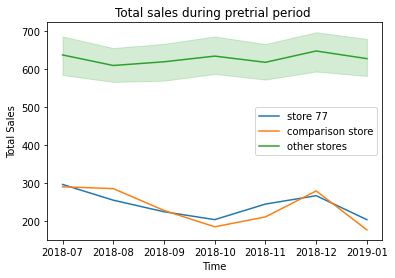

In [39]:
preTrialMeasures_store77 = preTrialMeasures[ preTrialMeasures.STORE_NBR == 77]
preTrialMeasures_store233 = preTrialMeasures[ preTrialMeasures.STORE_NBR == 233]
preTrialMeasures_other = preTrialMeasures[ preTrialMeasures.STORE_NBR != 77]

ax = plt.subplot()
sns.lineplot(x = 'month_year', y = 'totSales' , data = preTrialMeasures_store77, ax = ax)
sns.lineplot(x = 'month_year', y = 'totSales' , data = preTrialMeasures_store233, ax = ax)
sns.lineplot(x = 'month_year', y = 'totSales' , data = preTrialMeasures_other, estimator= np.mean,ax = ax)
ax.set_title('Total sales during pretrial period ')
ax.set_xlabel('Time')
ax.set_ylabel('Total Sales')
ax.legend(['store 77', 'comparison store', 'other stores'])

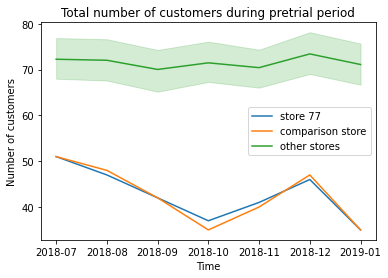

In [40]:
preTrialMeasures_store77 = preTrialMeasures[ preTrialMeasures.STORE_NBR == 77]
preTrialMeasures_store233 = preTrialMeasures[ preTrialMeasures.STORE_NBR == 233]
preTrialMeasures_other = preTrialMeasures[ preTrialMeasures.STORE_NBR != 77]

ax = plt.subplot()
sns.lineplot(x = 'month_year', y = 'nCustomers' , data = preTrialMeasures_store77, ax = ax)
sns.lineplot(x = 'month_year', y = 'nCustomers' , data = preTrialMeasures_store233, ax = ax)
sns.lineplot(x = 'month_year', y = 'nCustomers' , data = preTrialMeasures_other, estimator= np.mean, ax = ax)
ax.set_title('Total number of customers during pretrial period')
ax.set_xlabel('Time')
ax.set_ylabel('Number of customers')
ax.legend(['store 77', 'comparison store', 'other stores'])

Measures (total Sales and total number of customers) follow the same trend for both stores.

### Total sales and number of customers during pretrial period for store number 86

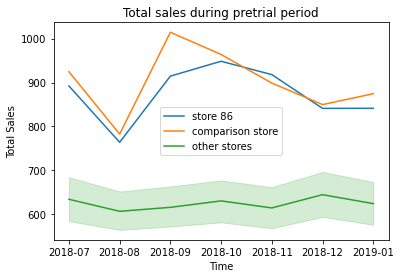

In [41]:
preTrialMeasures_store86 = preTrialMeasures[ preTrialMeasures.STORE_NBR == 86]
preTrialMeasures_store155 = preTrialMeasures[ preTrialMeasures.STORE_NBR == 155]
preTrialMeasures_other = preTrialMeasures[ preTrialMeasures.STORE_NBR != 86]

ax = plt.subplot()
sns.lineplot(x = 'month_year', y = 'totSales' , data = preTrialMeasures_store86, ax = ax)
sns.lineplot(x = 'month_year', y = 'totSales' , data = preTrialMeasures_store155, ax = ax)
sns.lineplot(x = 'month_year', y = 'totSales' , data = preTrialMeasures_other, estimator= np.mean, ax = ax)
ax.set_title('Total sales during pretrial period')
ax.set_xlabel('Time')
ax.set_ylabel('Total Sales')
ax.legend(['store 86', 'comparison store', 'other stores'])

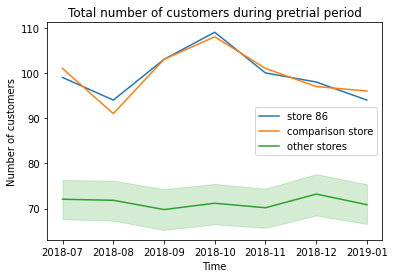

In [42]:
preTrialMeasures_store86 = preTrialMeasures[ preTrialMeasures.STORE_NBR == 86]
preTrialMeasures_store155 = preTrialMeasures[ preTrialMeasures.STORE_NBR == 155]
preTrialMeasures_other = preTrialMeasures[ preTrialMeasures.STORE_NBR != 86]

ax = plt.subplot()
sns.lineplot(x = 'month_year', y = 'nCustomers' , data = preTrialMeasures_store86, ax = ax)
sns.lineplot(x = 'month_year', y = 'nCustomers' , data = preTrialMeasures_store155, ax = ax)
sns.lineplot(x = 'month_year', y = 'nCustomers' , data = preTrialMeasures_other, estimator= np.mean, ax = ax)
ax.set_title('Total number of customers during pretrial period')
ax.set_xlabel('Time')
ax.set_ylabel('Number of customers')
ax.legend(['store 86', 'comparison store', 'other stores'])

Measures (total Sales and total number of customers) follow the same trend for both stores.

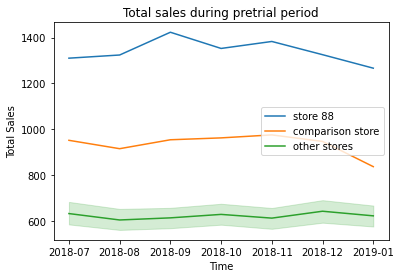

In [43]:
preTrialMeasures_store88 = preTrialMeasures[ preTrialMeasures.STORE_NBR == 88]
preTrialMeasures_store178 = preTrialMeasures[ preTrialMeasures.STORE_NBR == 178]
preTrialMeasures_other = preTrialMeasures[ preTrialMeasures.STORE_NBR != 88]

ax = plt.subplot()
sns.lineplot(x = 'month_year', y = 'totSales' , data = preTrialMeasures_store88, ax = ax)
sns.lineplot(x = 'month_year', y = 'totSales' , data = preTrialMeasures_store178, ax = ax)
sns.lineplot(x = 'month_year', y = 'totSales' , data = preTrialMeasures_other, estimator= np.mean, ax = ax)
ax.set_title('Total sales during pretrial period')
ax.set_xlabel('Time')
ax.set_ylabel('Total Sales')
ax.legend(['store 88', 'comparison store', 'other stores'])

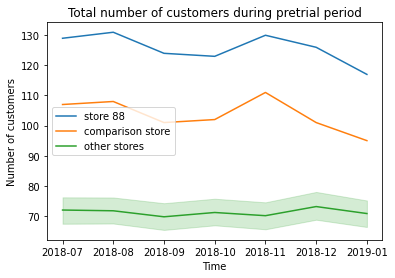

In [44]:
preTrialMeasures_store88 = preTrialMeasures[ preTrialMeasures.STORE_NBR == 88]
preTrialMeasures_store178 = preTrialMeasures[ preTrialMeasures.STORE_NBR == 178]
preTrialMeasures_other = preTrialMeasures[ preTrialMeasures.STORE_NBR != 88]

ax = plt.subplot()
sns.lineplot(x = 'month_year', y = 'nCustomers' , data = preTrialMeasures_store88, ax = ax)
sns.lineplot(x = 'month_year', y = 'nCustomers' , data = preTrialMeasures_store178, ax = ax)
sns.lineplot(x = 'month_year', y = 'nCustomers' , data = preTrialMeasures_other, estimator= np.mean, ax = ax)
ax.set_title('Total number of customers during pretrial period')
ax.set_xlabel('Time')
ax.set_ylabel('Number of customers')
ax.legend(['store 88', 'comparison store', 'other stores'])

Measures (total Sales and total number of customers) do not follow the same trend for both stores.

## Assessment of trial


The trial period goes from the start of February 2019 to April 2019.  We now want to
see if there has been an uplift in overall chip sales. I'll start with scaling the control store's sales to a level similar to control for any differences between the two stores outside of the trial period.

# Store no.77

### Scale pre-trial control sales to match pre-trial trial store sales

In [45]:
scalingFactorForControlSales  = preTrialMeasures[preTrialMeasures.STORE_NBR == 77].totSales.sum() / preTrialMeasures[preTrialMeasures.STORE_NBR == 233].totSales.sum()
scalingFactorForControlSales

measureOverTimeSales = measures_over_time.copy()
measureOverTimeSales.loc[ measureOverTimeSales.STORE_NBR == 233, 'totSales'] = measureOverTimeSales.loc[ measureOverTimeSales.STORE_NBR == 233, 'totSales'] * scalingFactorForControlSales
scaledControlSales = measureOverTimeSales[ measureOverTimeSales.STORE_NBR == 233]
scaledControlSales

,STORE_NBR,month_year,totSales,nCustomers,avgPricePerUnit,nTxnPerCust,nChipsPerTxn
2699,233,2018-07,297.565550,51,3.344444,1.058824,1.725490
2700,233,2018-08,292.652187,48,3.528000,1.041667,1.666667
2701,233,2018-09,233.998916,42,3.277778,1.071429,1.666667
2702,233,2018-10,190.085733,35,3.319444,1.028571,1.600000
2703,233,2018-11,216.597421,40,3.487805,1.025000,1.550000
2704,233,2018-12,286.408121,47,3.694000,1.063830,1.595745
2705,233,2019-01,181.692071,35,3.717143,1.000000,1.342857
2706,233,2019-02,249.762622,45,3.491489,1.044444,1.555556
2707,233,2019-03,203.802205,40,3.373171,1.025000,1.475000
2708,233,2019-04,162.345704,30,3.436364,1.100000,1.533333


### Percentage diffrences
Now I have comparable sales figures for the control store, I will calculate the percentage diffrence between the scaled  control sales and the trial store's sales during the trial period.

In [46]:
measureOverTimeSalesStore77 = measureOverTimeSales.loc[ (measureOverTimeSales.STORE_NBR == 77)]
percentageDiff  = pd.merge(measureOverTimeSalesStore77, scaledControlSales, on = 'month_year', suffixes=('_trial', '_control'))
percentageDiff

,STORE_NBR_trial,month_year,totSales_trial,nCustomers_trial,avgPricePerUnit_trial,nTxnPerCust_trial,nChipsPerTxn_trial,STORE_NBR_control,totSales_control,nCustomers_control,avgPricePerUnit_control,nTxnPerCust_control,nChipsPerTxn_control
0,77,2018-07,296.8,51,3.545455,1.078431,1.647059,233,297.565550,51,3.344444,1.058824,1.725490
1,77,2018-08,255.5,47,3.439583,1.021277,1.574468,233,292.652187,48,3.528000,1.041667,1.666667
2,77,2018-09,225.2,42,3.234091,1.047619,1.666667,233,233.998916,42,3.277778,1.071429,1.666667
3,77,2018-10,204.5,37,3.876316,1.027027,1.405405,233,190.085733,35,3.319444,1.028571,1.600000
4,77,2018-11,245.3,41,3.765909,1.073171,1.634146,233,216.597421,40,3.487805,1.025000,1.550000
5,77,2018-12,267.3,46,3.708163,1.065217,1.565217,233,286.408121,47,3.694000,1.063830,1.595745
6,77,2019-01,204.4,35,3.125641,1.114286,1.857143,233,181.692071,35,3.717143,1.000000,1.342857
7,77,2019-02,235.0,45,3.193333,1.000000,1.644444,233,249.762622,45,3.491489,1.044444,1.555556
8,77,2019-03,278.5,50,3.481818,1.100000,1.640000,233,203.802205,40,3.373171,1.025000,1.475000
9,77,2019-04,263.5,47,3.431250,1.021277,1.659574,233,162.345704,30,3.436364,1.100000,1.533333


### Compute percentage diffrence

In [47]:
percentageDiff['percentageDiffSales'] = abs(percentageDiff.totSales_control - percentageDiff.totSales_trial)/ percentageDiff.totSales_control
diffDuringPreTrial = percentageDiff[percentageDiff.month_year < '2019-02'].percentageDiffSales
diffDuringPreTrial

0    0.002573
1    0.126950
2    0.037602
3    0.075830
4    0.132516
5    0.066716
6    0.124980
Name: percentageDiffSales, dtype: float64

One sample t test determines whether the sample mean is statistically diffrent from a known or hypothesized population mean. 

H0: the trial period is the same as the pre-trial period.

In [48]:
stdDev_pretrial = np.std(diffDuringPreTrial)
degreesOfFreedom = 7

T critic for a probaibility of 0.95 and 7 degrees of freedom

In [49]:
t_critic = 1.895

We will test with a null hypothesis of there being 0 diffrence between trial and control stores.

In [50]:
t_calc = (percentageDiff.loc[percentageDiff.month_year.between('2019-02', '2019-04'),'percentageDiffSales'] - 0) / stdDev_pretrial
t_calc

7     1.278363
8     7.927151
9    13.476023
Name: percentageDiffSales, dtype: float64

The calculated t value is then compared to the critical t value from the t distribution table with degrees of freedom df = n - 1 and chosen confidence level. If the calculated t value > critical t value, then we reject the null hypothesis.

In [51]:
t_calc > t_critic

7    False
8     True
9     True
Name: percentageDiffSales, dtype: bool

We can observe that the t-value is  larger than the 95th percentile value of the t-distribution for  March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.

### Number of customers

### Scale pre-trial control sales to match pre-trial trial store customers

In [52]:
scalingFactorForControlnCustomers  = preTrialMeasures[preTrialMeasures.STORE_NBR == 77].nCustomers.sum() / preTrialMeasures[preTrialMeasures.STORE_NBR == 233].nCustomers.sum()
scalingFactorForControlnCustomers

measureOverTimenCustomers = measures_over_time.copy()
measureOverTimenCustomers.loc[ measureOverTimenCustomers.STORE_NBR == 233, 'nCustomers'] = measureOverTimenCustomers.loc[ measureOverTimenCustomers.STORE_NBR == 233, 'nCustomers'] * scalingFactorForControlnCustomers
scaledControlnCustomers = measureOverTimenCustomers[ measureOverTimenCustomers.STORE_NBR == 233]
scaledControlnCustomers

,STORE_NBR,month_year,totSales,nCustomers,avgPricePerUnit,nTxnPerCust,nChipsPerTxn
2699,233,2018-07,290.7,51.171141,3.344444,1.058824,1.725490
2700,233,2018-08,285.9,48.161074,3.528000,1.041667,1.666667
2701,233,2018-09,228.6,42.140940,3.277778,1.071429,1.666667
2702,233,2018-10,185.7,35.117450,3.319444,1.028571,1.600000
2703,233,2018-11,211.6,40.134228,3.487805,1.025000,1.550000
2704,233,2018-12,279.8,47.157718,3.694000,1.063830,1.595745
2705,233,2019-01,177.5,35.117450,3.717143,1.000000,1.342857
2706,233,2019-02,244.0,45.151007,3.491489,1.044444,1.555556
2707,233,2019-03,199.1,40.134228,3.373171,1.025000,1.475000
2708,233,2019-04,158.6,30.100671,3.436364,1.100000,1.533333


### Percentage diffrences
Now I have comparable sales figures for the control store, I will calculate the percentage diffrence between the scaled  control customers and the trial store's customers during the trial period.

In [53]:
measureOverTimenCustomersStore77 = measureOverTimenCustomers.loc[ (measureOverTimenCustomers.STORE_NBR == 77)]
percentageDiff  = pd.merge(measureOverTimenCustomersStore77, scaledControlnCustomers, on = 'month_year', suffixes=('_trial', '_control'))
percentageDiff

,STORE_NBR_trial,month_year,totSales_trial,nCustomers_trial,avgPricePerUnit_trial,nTxnPerCust_trial,nChipsPerTxn_trial,STORE_NBR_control,totSales_control,nCustomers_control,avgPricePerUnit_control,nTxnPerCust_control,nChipsPerTxn_control
0,77,2018-07,296.8,51.0,3.545455,1.078431,1.647059,233,290.7,51.171141,3.344444,1.058824,1.725490
1,77,2018-08,255.5,47.0,3.439583,1.021277,1.574468,233,285.9,48.161074,3.528000,1.041667,1.666667
2,77,2018-09,225.2,42.0,3.234091,1.047619,1.666667,233,228.6,42.140940,3.277778,1.071429,1.666667
3,77,2018-10,204.5,37.0,3.876316,1.027027,1.405405,233,185.7,35.117450,3.319444,1.028571,1.600000
4,77,2018-11,245.3,41.0,3.765909,1.073171,1.634146,233,211.6,40.134228,3.487805,1.025000,1.550000
5,77,2018-12,267.3,46.0,3.708163,1.065217,1.565217,233,279.8,47.157718,3.694000,1.063830,1.595745
6,77,2019-01,204.4,35.0,3.125641,1.114286,1.857143,233,177.5,35.117450,3.717143,1.000000,1.342857
7,77,2019-02,235.0,45.0,3.193333,1.000000,1.644444,233,244.0,45.151007,3.491489,1.044444,1.555556
8,77,2019-03,278.5,50.0,3.481818,1.100000,1.640000,233,199.1,40.134228,3.373171,1.025000,1.475000
9,77,2019-04,263.5,47.0,3.431250,1.021277,1.659574,233,158.6,30.100671,3.436364,1.100000,1.533333


### Compute percentage diffrence

In [54]:
percentageDiff['percentageDiffnCustomers'] = abs(percentageDiff.nCustomers_control - percentageDiff.nCustomers_trial)/ percentageDiff.nCustomers_control
diffDuringPreTrial = percentageDiff[percentageDiff.month_year < '2019-02'].percentageDiffnCustomers
diffDuringPreTrial

0    0.003344
1    0.024108
2    0.003344
3    0.053607
4    0.021572
5    0.024550
6    0.003344
Name: percentageDiffnCustomers, dtype: float64

One sample t test determines whether the sample mean is statistically diffrent from a known or hypothesized population mean. 

H0: the trial period is the same as the pre-trial period.

In [55]:
stdDev_pretrial = np.std(diffDuringPreTrial)
degreesOfFreedom = 7

We will test with a null hypothesis of there being 0 diffrence between trial and control stores.

In [56]:
t_calc = (percentageDiff.loc[percentageDiff.month_year.between('2019-02', '2019-04'),'percentageDiffnCustomers'] - 0) / stdDev_pretrial
t_calc

7     0.198043
8    14.556162
9    33.244822
Name: percentageDiffnCustomers, dtype: float64

The calculated t value is then compared to the critical t value from the t distribution table with degrees of freedom df = n - 1 and chosen confidence level. If the calculated t value > critical t value, then we reject the null hypothesis.

In [57]:
t_calc > t_critic

7    False
8     True
9     True
Name: percentageDiffnCustomers, dtype: bool

We can observe that the t-value is  larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in customers in the trial store in March and April is statistically greater than in the control store.

# Store no.86

### Scale pre-trial control sales to match pre-trial trial store sales

In [58]:
factor  = preTrialMeasures[preTrialMeasures.STORE_NBR == 86].totSales.sum() / preTrialMeasures[preTrialMeasures.STORE_NBR == 155].totSales.sum()
factor

measuresOverTimeSales = measures_over_time.copy()

In [59]:
measuresOverTimeSales.loc[ measuresOverTimeSales.STORE_NBR == 155, 'totSales'] = measuresOverTimeSales.loc[ measuresOverTimeSales.STORE_NBR == 155, 'totSales'] * factor
scaledControlSales = measuresOverTimeSales[ measuresOverTimeSales.STORE_NBR == 155]
scaledControlSales

,STORE_NBR,month_year,totSales,nCustomers,avgPricePerUnit,nTxnPerCust,nChipsPerTxn
1793,155,2018-07,896.922236,101,3.698400,1.237624,2.475248
1794,155,2018-08,759.269991,91,3.451667,1.318681,2.516484
1795,155,2018-09,984.034086,103,3.497931,1.407767,2.815534
1796,155,2018-10,934.948790,108,3.543382,1.259259,2.518519
1797,155,2018-11,871.894555,101,3.328889,1.336634,2.673267
1798,155,2018-12,824.361363,97,3.511570,1.247423,2.494845
1799,155,2019-01,848.418979,96,3.470635,1.312500,2.625000
1800,155,2019-02,864.522060,95,3.508661,1.336842,2.673684
1801,155,2019-03,780.320405,94,3.351667,1.276596,2.553191
1802,155,2019-04,819.317024,99,3.490083,1.222222,2.444444


### Percentage diffrences
Now I have comparable sales figures for the control store, I will calculate the percentage diffrence between the scaled  control sales and the trial store's sales during the trial period.

In [60]:
measureOverTimeSalesStore86 = measuresOverTimeSales.loc[ (measuresOverTimeSales.STORE_NBR == 86)]
perceDiff  = pd.merge(measureOverTimeSalesStore86, scaledControlSales, on = 'month_year', suffixes=('_trial', '_control'))
perceDiff

,STORE_NBR_trial,month_year,totSales_trial,nCustomers_trial,avgPricePerUnit_trial,nTxnPerCust_trial,nChipsPerTxn_trial,STORE_NBR_control,totSales_control,nCustomers_control,avgPricePerUnit_control,nTxnPerCust_control,nChipsPerTxn_control
0,86,2018-07,892.20,99,3.555556,1.272727,2.535354,155,896.922236,101,3.698400,1.237624,2.475248
1,86,2018-08,764.05,94,3.584375,1.191489,2.287234,155,759.269991,91,3.451667,1.318681,2.516484
2,86,2018-09,914.60,103,3.544961,1.252427,2.504854,155,984.034086,103,3.497931,1.407767,2.815534
3,86,2018-10,948.40,109,3.436232,1.266055,2.532110,155,934.948790,108,3.543382,1.259259,2.518519
4,86,2018-11,918.00,100,3.614173,1.270000,2.540000,155,871.894555,101,3.328889,1.336634,2.673267
5,86,2018-12,841.20,98,3.505000,1.224490,2.448980,155,824.361363,97,3.511570,1.247423,2.494845
6,86,2019-01,841.40,94,3.236154,1.382979,2.765957,155,848.418979,96,3.470635,1.312500,2.625000
7,86,2019-02,913.20,107,3.298561,1.299065,2.588785,155,864.522060,95,3.508661,1.336842,2.673684
8,86,2019-03,1026.80,115,3.615493,1.234783,2.469565,155,780.320405,94,3.351667,1.276596,2.553191
9,86,2019-04,848.20,105,3.339370,1.209524,2.419048,155,819.317024,99,3.490083,1.222222,2.444444


### Compute percentage diffrence

In [61]:
perceDiff['percentageDiffSales'] = abs(perceDiff.totSales_control - perceDiff.totSales_trial)/ perceDiff.totSales_control
diffDuringPreTrial = perceDiff[perceDiff.month_year < '2019-02'].percentageDiffSales
diffDuringPreTrial

0    0.005265
1    0.006296
2    0.070561
3    0.014387
4    0.052880
5    0.020426
6    0.008273
Name: percentageDiffSales, dtype: float64

One sample t test determines whether the sample mean is statistically diffrent from a known or hypothesized population mean. 

H0: the trial period is the same as the pre-trial period.

In [62]:
stdDev_pretrial = np.std(diffDuringPreTrial)
degreesOfFreedom = 7

T critic for a probaibility of 0.95 and 7 degrees of freedom

In [63]:
t_critic = 1.895

We will test with a null hypothesis of there being 0 diffrence between trial and control stores.

In [64]:
t_calc = (perceDiff.loc[perceDiff.month_year.between('2019-02', '2019-04'),'percentageDiffSales'] - 0) / stdDev_pretrial
t_calc

7     2.354174
8    13.206585
9     1.473915
Name: percentageDiffSales, dtype: float64

The calculated t value is then compared to the critical t value from the t distribution table with degrees of freedom df = n - 1 and chosen confidence level. If the calculated t value > critical t value, then we reject the null hypothesis.

In [65]:
t_calc > t_critic

7     True
8     True
9    False
Name: percentageDiffSales, dtype: bool

We can observe that the t-value is  larger than the 95th percentile value of the t-distribution for February and  March - i.e. the increase in sales in the trial store in February and March is statistically greater than in the control store.

### Number of customers

### Scale pre-trial control sales to match pre-trial trial store customers

In [66]:
scalingFactorForControlnCustomers = preTrialMeasures[preTrialMeasures.STORE_NBR == 86].nCustomers.sum() / preTrialMeasures[preTrialMeasures.STORE_NBR == 155].nCustomers.sum()
scalingFactorForControlnCustomers

measureOverTimenCustomers = measures_over_time.copy()
measureOverTimenCustomers.loc[ measureOverTimenCustomers.STORE_NBR == 155, 'nCustomers'] = measureOverTimenCustomers.loc[ measureOverTimenCustomers.STORE_NBR == 155, 'nCustomers'] * scalingFactorForControlnCustomers
scaledControlnCustomers = measureOverTimenCustomers[ measureOverTimenCustomers.STORE_NBR == 155]
scaledControlnCustomers

,STORE_NBR,month_year,totSales,nCustomers,avgPricePerUnit,nTxnPerCust,nChipsPerTxn
1793,155,2018-07,924.60,101.0,3.698400,1.237624,2.475248
1794,155,2018-08,782.70,91.0,3.451667,1.318681,2.516484
1795,155,2018-09,1014.40,103.0,3.497931,1.407767,2.815534
1796,155,2018-10,963.80,108.0,3.543382,1.259259,2.518519
1797,155,2018-11,898.80,101.0,3.328889,1.336634,2.673267
1798,155,2018-12,849.80,97.0,3.511570,1.247423,2.494845
1799,155,2019-01,874.60,96.0,3.470635,1.312500,2.625000
1800,155,2019-02,891.20,95.0,3.508661,1.336842,2.673684
1801,155,2019-03,804.40,94.0,3.351667,1.276596,2.553191
1802,155,2019-04,844.60,99.0,3.490083,1.222222,2.444444


### Percentage diffrences
Now I have comparable sales figures for the control store, I will calculate the percentage diffrence between the scaled  control customers and the trial store's customers during the trial period.

In [67]:
measureOverTimenCustomersStore86 = measureOverTimenCustomers.loc[ (measureOverTimenCustomers.STORE_NBR == 86)]
percentageDiff  = pd.merge(measureOverTimenCustomersStore86, scaledControlnCustomers, on = 'month_year', suffixes=('_trial', '_control'))
percentageDiff

,STORE_NBR_trial,month_year,totSales_trial,nCustomers_trial,avgPricePerUnit_trial,nTxnPerCust_trial,nChipsPerTxn_trial,STORE_NBR_control,totSales_control,nCustomers_control,avgPricePerUnit_control,nTxnPerCust_control,nChipsPerTxn_control
0,86,2018-07,892.20,99.0,3.555556,1.272727,2.535354,155,924.60,101.0,3.698400,1.237624,2.475248
1,86,2018-08,764.05,94.0,3.584375,1.191489,2.287234,155,782.70,91.0,3.451667,1.318681,2.516484
2,86,2018-09,914.60,103.0,3.544961,1.252427,2.504854,155,1014.40,103.0,3.497931,1.407767,2.815534
3,86,2018-10,948.40,109.0,3.436232,1.266055,2.532110,155,963.80,108.0,3.543382,1.259259,2.518519
4,86,2018-11,918.00,100.0,3.614173,1.270000,2.540000,155,898.80,101.0,3.328889,1.336634,2.673267
5,86,2018-12,841.20,98.0,3.505000,1.224490,2.448980,155,849.80,97.0,3.511570,1.247423,2.494845
6,86,2019-01,841.40,94.0,3.236154,1.382979,2.765957,155,874.60,96.0,3.470635,1.312500,2.625000
7,86,2019-02,913.20,107.0,3.298561,1.299065,2.588785,155,891.20,95.0,3.508661,1.336842,2.673684
8,86,2019-03,1026.80,115.0,3.615493,1.234783,2.469565,155,804.40,94.0,3.351667,1.276596,2.553191
9,86,2019-04,848.20,105.0,3.339370,1.209524,2.419048,155,844.60,99.0,3.490083,1.222222,2.444444


### Compute percentage diffrence

In [68]:
percentageDiff['percentageDiffnCustomers'] = abs(percentageDiff.nCustomers_control - percentageDiff.nCustomers_trial)/ percentageDiff.nCustomers_control
diffDuringPreTrial = percentageDiff[percentageDiff.month_year < '2019-02'].percentageDiffnCustomers
diffDuringPreTrial

0    0.019802
1    0.032967
2    0.000000
3    0.009259
4    0.009901
5    0.010309
6    0.020833
Name: percentageDiffnCustomers, dtype: float64

One sample t test determines whether the sample mean is statistically diffrent from a known or hypothesized population mean. 

H0: the trial period is the same as the pre-trial period.

In [69]:
stdDev_pretrial = np.std(diffDuringPreTrial)
degreesOfFreedom = 7

We will test with a null hypothesis of there being 0 diffrence between trial and control stores.

In [70]:
t_calc = (percentageDiff.loc[percentageDiff.month_year.between('2019-02', '2019-04'),'percentageDiffnCustomers'] - 0) / stdDev_pretrial
t_calc

7    12.766068
8    22.578285
9     6.125134
Name: percentageDiffnCustomers, dtype: float64

The calculated t value is then compared to the critical t value from the t distribution table with degrees of freedom df = n - 1 and chosen confidence level. If the calculated t value > critical t value, then we reject the null hypothesis.

In [71]:
t_calc > t_critic

7    True
8    True
9    True
Name: percentageDiffnCustomers, dtype: bool

We can observe that the t-value is larger than the 95th percentile value of the t-distribution for February, March and April - i.e. the increase in customers in the trial store in March and April is statistically greater than in the control store.

# Conclusions

The results for trial stores 77 and 86 during the trial period show a significant
difference in at least two of the three trial months but this is not the case for
trial store 88, since I didn't find a similar store for 88. We can check with the client if the implementation of the trial was
different in trial store 88 but overall, the trial shows a significant increase in
sales.

Bibliography:
1. https://www.insidesherpa.com/
2. https://insidesherpa.s3.amazonaws.com/vinternships/companyassets/32A6DqtsbF7LbKdcq/InsideSherpa_Task2_DraftSolutions%20-%20Template.pdf
3. https://libguides.library.kent.edu/SPSS/OneSampletTest
4. https://www.sjsu.edu/faculty/gerstman/StatPrimer/t-table.pdf